C:\Users\dines\AppData\Local\Temp\ipykernel_5444\3412473327.py:50: DeprecationWarning: Call to deprecated function stored_results. Reason: The property counterpart 'stored_results' will be added in a future release, and this method will be removed.
  for result in cursor.stored_results():
C:\Users\dines\AppData\Local\Temp\ipykernel_5444\3412473327.py:50: DeprecationWarning: Call to deprecated function stored_results. Reason: The property counterpart 'stored_results' will be added in a future release, and this method will be removed.
  for result in cursor.stored_results():
C:\Users\dines\AppData\Local\Temp\ipykernel_5444\3412473327.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="city", y="total_customers", ax=ax, palette=PALETTES["p2"])
C:\Users\dines\AppData\Local\Temp\ipykernel_5444\3412473327.py:50: DeprecationWarnin

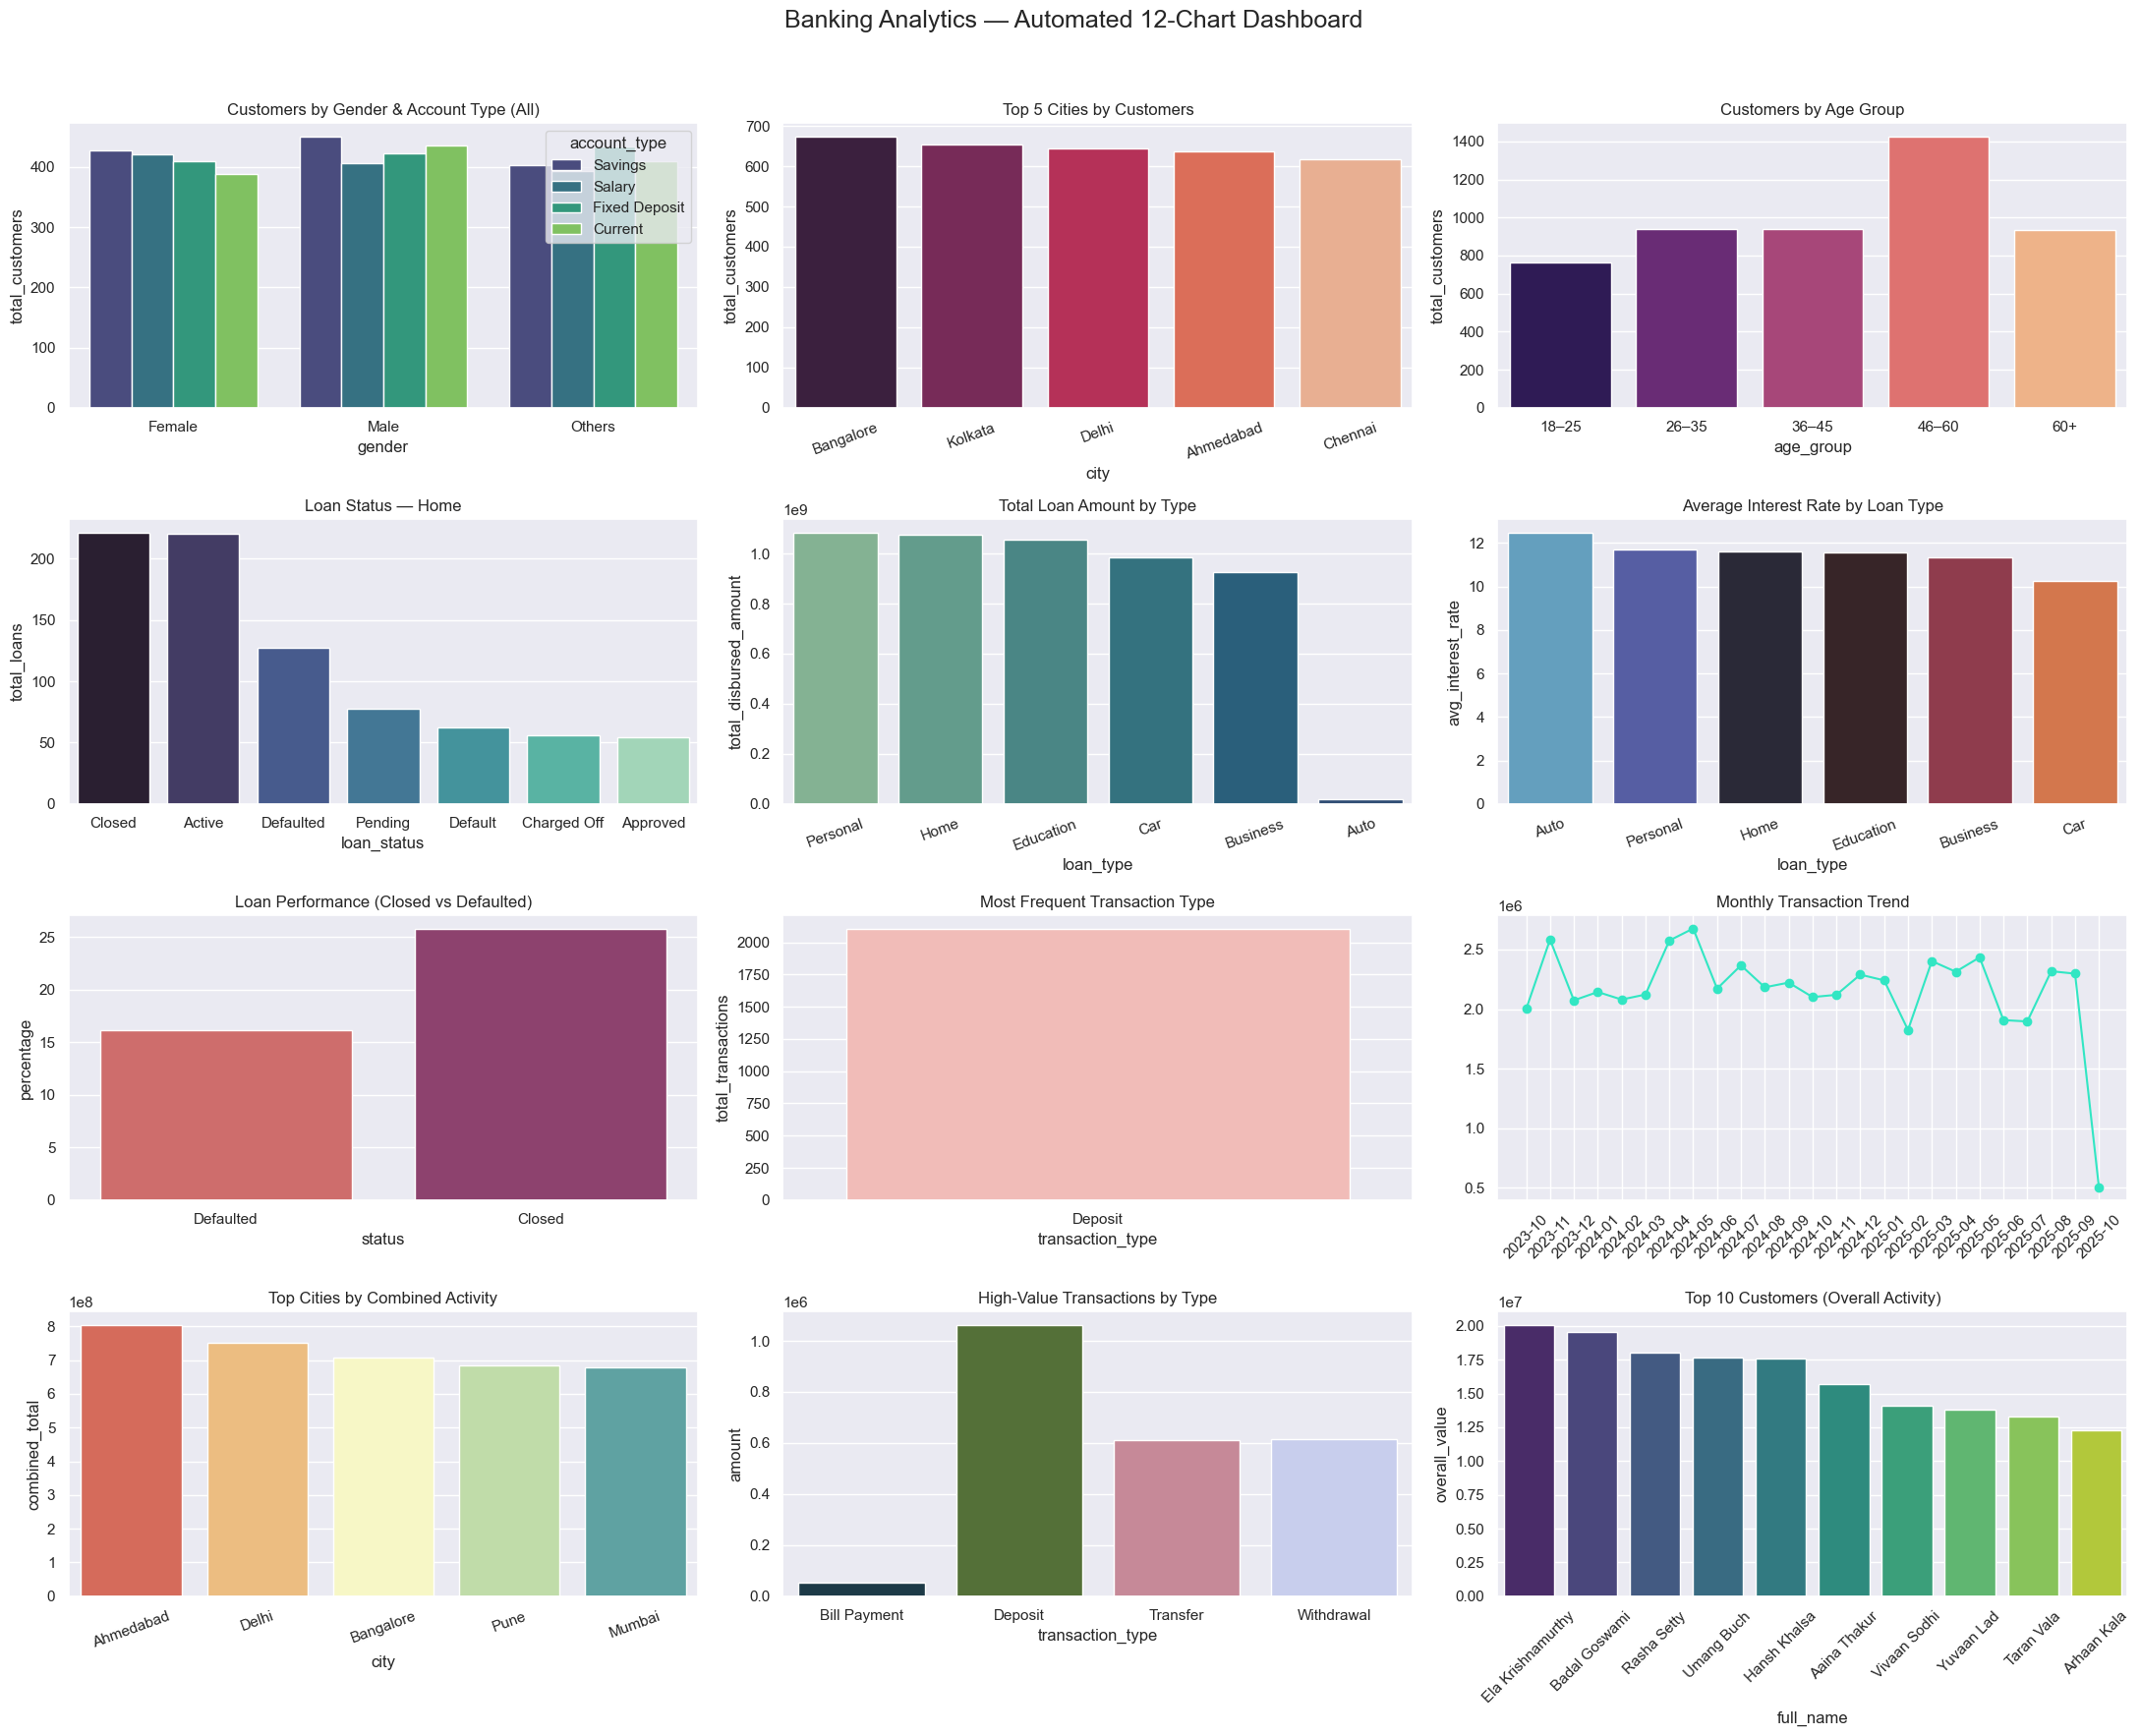

In [1]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mysql.connector import Error

# =========================
# DB CONFIG
# =========================
DB_CONFIG = {
    "host": "localhost",
    "user": "root",
    "password": "14032002kD@",
    "database": "Banking"
}

# =========================
# THEMING (Dark Mode T3)
# =========================
plt.style.use('dark_background')
sns.set_theme(style="darkgrid")

PALETTES = {
    "p1": "viridis",
    "p2": "rocket",
    "p3": "magma",
    "p4": "mako",
    "p5": "crest",
    "p6": "icefire",
    "p7": "flare",
    "p8": "Pastel1",
    "p9": "Spectral",
    "p10": "cubehelix"
}

# =========================
# DB HELPER
# =========================
def run_proc(proc_name, params=None):
    conn = None
    try:
        conn = mysql.connector.connect(**DB_CONFIG)
        cursor = conn.cursor()
        if params is not None:
            cursor.callproc(proc_name, params)
        else:
            cursor.callproc(proc_name)

        df = None
        for result in cursor.stored_results():
            rows = result.fetchall()
            cols = [c[0] for c in result.description]
            df = pd.DataFrame(rows, columns=cols)

        return df, params
    except Error as e:
        print(f"❌ Error running {proc_name}: {e}")
        return None, params
    finally:
        try:
            cursor.close()
        except:
            pass
        if conn and conn.is_connected():
            conn.close()

# =========================
# SAFE HELPERS
# =========================
def plot_no_data(ax, title):
    ax.set_title(title)
    ax.text(0.5, 0.5, "No Data", ha="center", va="center", fontsize=12)
    ax.axis("off")

def sort_desc(df, col):
    if df is None or df.empty or col not in df.columns:
        return df
    return df.sort_values(col, ascending=False)

# =========================
# MAIN DASHBOARD
# =========================
def build_dashboard():

    # DEFAULT VALUES (NO INPUT FROM USER)
    acc_type_filter = None
    loan_type_for_status = "Home"
    top_n_customers = 10
    hv_group_choice = "H1"

    fig, axes = plt.subplots(4, 3, figsize=(22, 18))
    fig.suptitle("Banking Analytics — Automated 12-Chart Dashboard", fontsize=18, y=0.98)

    # ---------------- Q1
    ax = axes[0, 0]
    params = [acc_type_filter, 0]
    df, updated = run_proc("total_customers_by_gender_account", params)
    ttl = "Customers by Gender & Account Type (All)"

    if df is None or df.empty:
        plot_no_data(ax, ttl)
    else:
        sns.barplot(data=df, x="gender", y="total_customers", hue="account_type", ax=ax, palette=PALETTES["p1"])
        ax.set_title(ttl)

    # ---------------- Q2
    ax = axes[0, 1]
    df, _ = run_proc("top_5_locations")
    ttl = "Top 5 Cities by Customers"

    if df is None or df.empty:
        plot_no_data(ax, ttl)
    else:
        sns.barplot(data=df, x="city", y="total_customers", ax=ax, palette=PALETTES["p2"])
        ax.set_title(ttl)
        plt.setp(ax.get_xticklabels(), rotation=20)

    # ---------------- Q3
    ax = axes[0, 2]
    df, _ = run_proc("customers_by_age_group")
    ttl = "Customers by Age Group"

    if df is None or df.empty:
        plot_no_data(ax, ttl)
    else:
        sns.barplot(data=df, x="age_group", y="total_customers", ax=ax, palette=PALETTES["p3"])
        ax.set_title(ttl)

    # ---------------- Q4
    ax = axes[1, 0]
    params = [loan_type_for_status, 0]
    df, _ = run_proc("count_loans_by_status", params)
    ttl = f"Loan Status — {loan_type_for_status}"

    if df is None or df.empty:
        plot_no_data(ax, ttl)
    else:
        sns.barplot(data=df, x="loan_status", y="total_loans", ax=ax, palette=PALETTES["p4"])
        ax.set_title(ttl)

    # ---------------- Q5
    ax = axes[1, 1]
    df, _ = run_proc("total_loan_amount_by_type")
    ttl = "Total Loan Amount by Type"

    if df is None or df.empty:
        plot_no_data(ax, ttl)
    else:
        sns.barplot(data=sort_desc(df, "total_disbursed_amount"), x="loan_type",
                    y="total_disbursed_amount", ax=ax, palette=PALETTES["p5"])
        ax.set_title(ttl)
        plt.setp(ax.get_xticklabels(), rotation=20)

    # ---------------- Q6
    ax = axes[1, 2]
    df, _ = run_proc("avg_interest_rate_by_type")
    ttl = "Average Interest Rate by Loan Type"

    if df is None or df.empty:
        plot_no_data(ax, ttl)
    else:
        sns.barplot(data=sort_desc(df, "avg_interest_rate"), x="loan_type",
                    y="avg_interest_rate", ax=ax, palette=PALETTES["p6"])
        ax.set_title(ttl)
        plt.setp(ax.get_xticklabels(), rotation=20)

    # ---------------- Q7
    ax = axes[2, 0]
    df, _ = run_proc("loan_performance_summary")
    ttl = "Loan Performance (Closed vs Defaulted)"

    if df is None or df.empty:
        plot_no_data(ax, ttl)
    else:
        sns.barplot(data=df, x="status", y="percentage", ax=ax, palette=PALETTES["p7"])
        ax.set_title(ttl)

    # ---------------- Q8
    ax = axes[2, 1]
    df, _ = run_proc("most_frequent_transaction_type")
    ttl = "Most Frequent Transaction Type"

    if df is None or df.empty:
        plot_no_data(ax, ttl)
    else:
        sns.barplot(data=df, x="transaction_type", y="total_transactions", ax=ax, palette=PALETTES["p8"])
        ax.set_title(ttl)

    # ---------------- Q9
    ax = axes[2, 2]
    df, _ = run_proc("monthly_transaction_trends")
    ttl = "Monthly Transaction Trend"

    if df is None or df.empty:
        plot_no_data(ax, ttl)
    else:
        df = df.sort_values("month")
        ax.plot(df["month"], df["total_transaction_amount"], marker="o", color="#32e6c3")
        ax.set_title(ttl)
        plt.setp(ax.get_xticklabels(), rotation=45)

    # ---------------- Q10
    ax = axes[3, 0]
    df, _ = run_proc("top_cities_by_financial_activity")
    ttl = "Top Cities by Combined Activity"

    if df is None or df.empty:
        plot_no_data(ax, ttl)
    else:
        sns.barplot(data=sort_desc(df, "combined_total"), x="city", y="combined_total",
                    ax=ax, palette=PALETTES["p9"])
        ax.set_title(ttl)
        plt.setp(ax.get_xticklabels(), rotation=20)

    # ---------------- Q11
    ax = axes[3, 1]
    df, _ = run_proc("high_value_transactions")
    ttl = "High-Value Transactions by Type"

    if df is None or df.empty:
        plot_no_data(ax, ttl)
    else:
        agg = df.groupby("transaction_type", as_index=False)["amount"].sum()
        sns.barplot(data=agg, x="transaction_type", y="amount",
                    ax=ax, palette=PALETTES["p10"])
        ax.set_title(ttl)

    # ---------------- Q12
    ax = axes[3, 2]
    df, _ = run_proc("topn_customers_activity", [top_n_customers])
    ttl = f"Top {top_n_customers} Customers (Overall Activity)"

    if df is None or df.empty:
        plot_no_data(ax, ttl)
    else:
        sns.barplot(data=sort_desc(df, "overall_value").head(top_n_customers),
                    x="full_name", y="overall_value", ax=ax, palette=PALETTES["p1"])
        ax.set_title(ttl)
        plt.setp(ax.get_xticklabels(), rotation=45)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# =========================
# EXECUTE
# =========================
if __name__ == "__main__":
    build_dashboard()


C:\Users\dines\AppData\Local\Temp\ipykernel_5444\77551195.py:51: DeprecationWarning: Call to deprecated function stored_results. Reason: The property counterpart 'stored_results' will be added in a future release, and this method will be removed.
  for result in cursor.stored_results():
C:\Users\dines\AppData\Local\Temp\ipykernel_5444\77551195.py:51: DeprecationWarning: Call to deprecated function stored_results. Reason: The property counterpart 'stored_results' will be added in a future release, and this method will be removed.
  for result in cursor.stored_results():
C:\Users\dines\AppData\Local\Temp\ipykernel_5444\77551195.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="city", y="total_customers",
C:\Users\dines\AppData\Local\Temp\ipykernel_5444\77551195.py:51: DeprecationWarning: Call to deprecated function stored_r

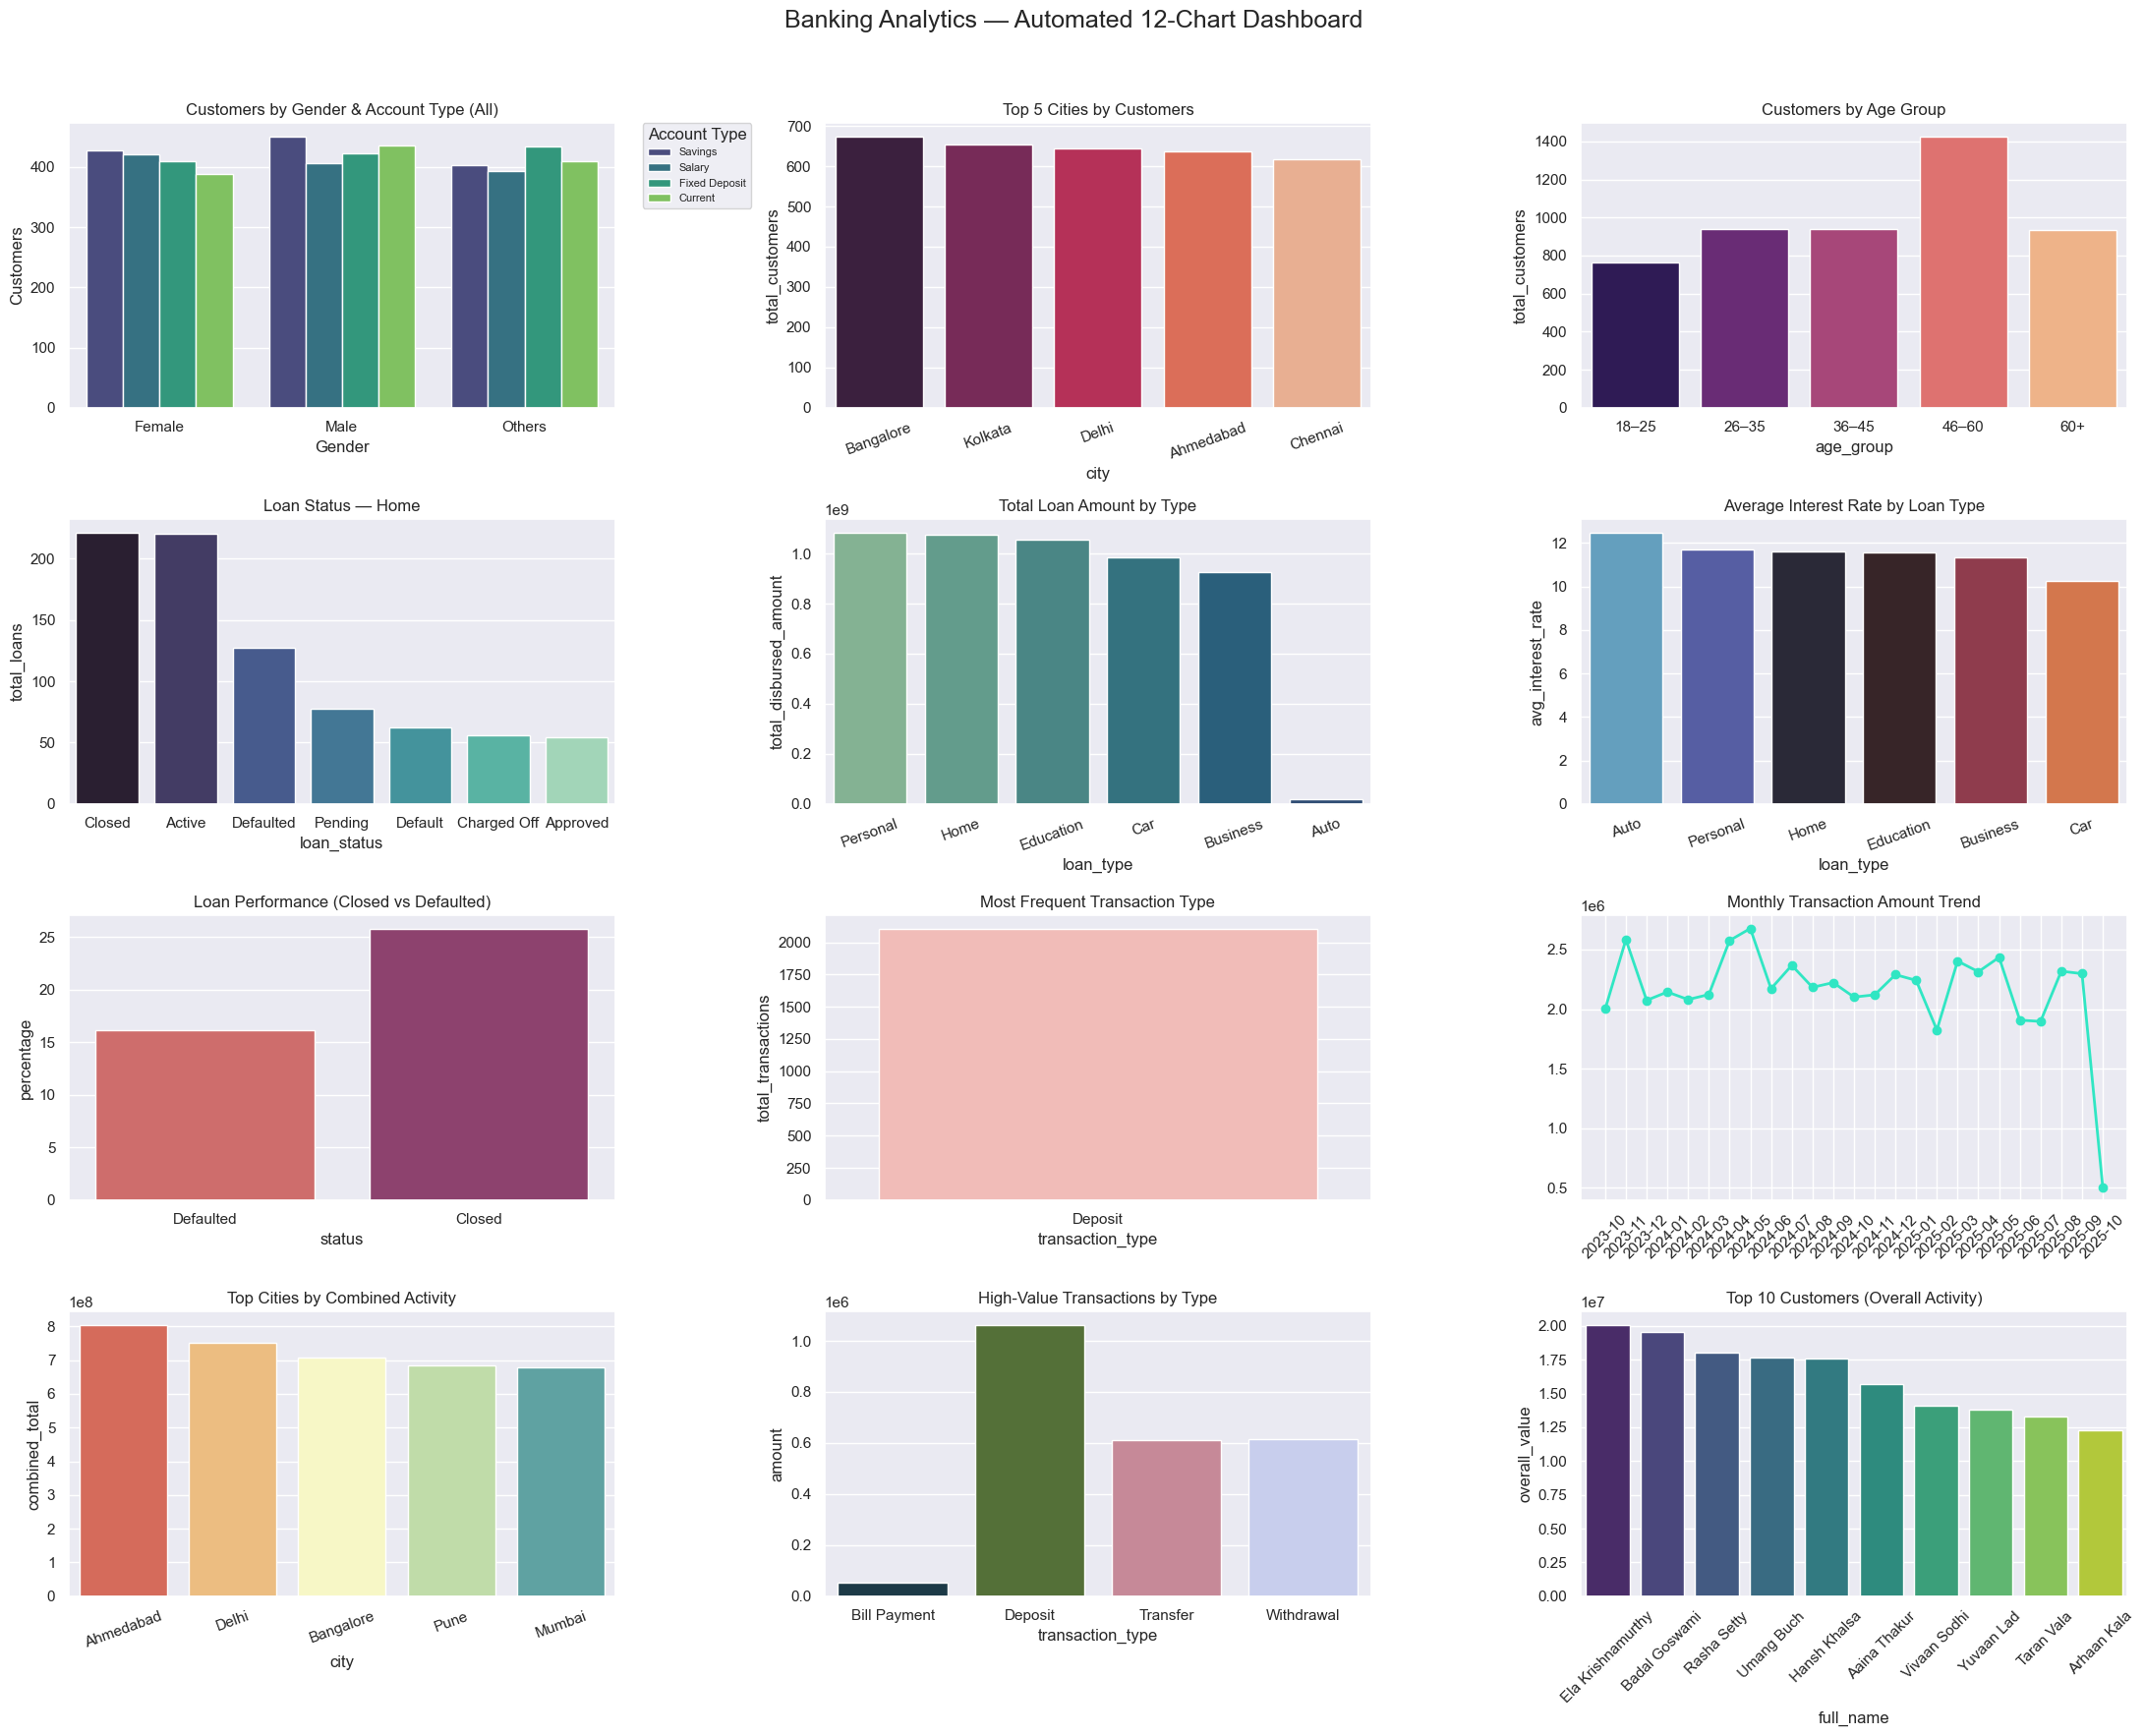

In [2]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mysql.connector import Error

# =========================
# DB CONFIG
# =========================
DB_CONFIG = {
    "host": "localhost",
    "user": "root",
    "password": "14032002kD@",
    "database": "Banking"
}

# =========================
# THEMING (Dark Mode)
# =========================
plt.style.use('dark_background')
sns.set_theme(style="darkgrid")

PALETTES = {
    "p1": "viridis",
    "p2": "rocket",
    "p3": "magma",
    "p4": "mako",
    "p5": "crest",
    "p6": "icefire",
    "p7": "flare",
    "p8": "Pastel1",
    "p9": "Spectral",
    "p10": "cubehelix"
}

# =========================
# STORED PROCEDURE EXECUTOR
# =========================
def run_proc(proc_name, params=None):
    conn = None
    try:
        conn = mysql.connector.connect(**DB_CONFIG)
        cursor = conn.cursor()

        if params is not None:
            cursor.callproc(proc_name, params)
        else:
            cursor.callproc(proc_name)

        df = None
        for result in cursor.stored_results():
            rows = result.fetchall()
            cols = [c[0] for c in result.description]
            df = pd.DataFrame(rows, columns=cols)

        return df, params

    except Error as e:
        print(f"❌ Error: {e}")
        return None, params

    finally:
        try: cursor.close()
        except: pass
        if conn and conn.is_connected(): conn.close()

# =========================
# SAFE HELPERS
# =========================
def plot_no_data(ax, title):
    ax.set_title(title)
    ax.text(0.5, 0.5, "No Data", ha="center", va="center", fontsize=12)
    ax.axis("off")

def sort_desc(df, col):
    if df is None or df.empty or col not in df.columns:
        return df
    return df.sort_values(col, ascending=False)

# =========================
# MAIN DASHBOARD
# =========================
def build_dashboard():

    # DEFAULT VALUES (NO USER INPUT)
    acc_type_filter = None
    loan_type_for_status = "Home"
    top_n_customers = 10
    hv_group_choice = "H1"

    fig, axes = plt.subplots(4, 3, figsize=(22, 18))
    fig.suptitle("Banking Analytics — Automated 12-Chart Dashboard", fontsize=18, y=0.98)

    # ============= Q1: Customers by Gender & Account Type (LEGEND FIXED)
    ax = axes[0, 0]
    params = [acc_type_filter, 0]
    df, updated = run_proc("total_customers_by_gender_account", params)
    ttl = "Customers by Gender & Account Type (All)"

    if df is None or df.empty:
        plot_no_data(ax, ttl)
    else:
        sns.barplot(data=df, x="gender", y="total_customers",
                    hue="account_type", ax=ax, palette=PALETTES["p1"])
        ax.set_title(ttl)
        ax.set_xlabel("Gender")
        ax.set_ylabel("Customers")

        # ⭐ FIXED: Move legend outside the plot
        ax.legend(title="Account Type", fontsize=8, bbox_to_anchor=(1.05, 1),
                  loc='upper left', borderaxespad=0.)

    # ============= Q2: Top Cities
    ax = axes[0, 1]
    df, _ = run_proc("top_5_locations")
    ttl = "Top 5 Cities by Customers"

    if df is None or df.empty:
        plot_no_data(ax, ttl)
    else:
        sns.barplot(data=df, x="city", y="total_customers",
                    ax=ax, palette=PALETTES["p2"])
        ax.set_title(ttl)
        plt.setp(ax.get_xticklabels(), rotation=20)

    # ============= Q3: Age Groups
    ax = axes[0, 2]
    df, _ = run_proc("customers_by_age_group")
    ttl = "Customers by Age Group"

    if df is None or df.empty:
        plot_no_data(ax, ttl)
    else:
        sns.barplot(data=df, x="age_group", y="total_customers",
                    ax=ax, palette=PALETTES["p3"])
        ax.set_title(ttl)

    # ============= Q4: Loan Status
    ax = axes[1, 0]
    params = [loan_type_for_status, 0]
    df, _ = run_proc("count_loans_by_status", params)
    ttl = f"Loan Status — {loan_type_for_status}"

    if df is None or df.empty:
        plot_no_data(ax, ttl)
    else:
        sns.barplot(data=df, x="loan_status", y="total_loans",
                    ax=ax, palette=PALETTES["p4"])
        ax.set_title(ttl)

    # ============= Q5: Loan Amount By Type
    ax = axes[1, 1]
    df, _ = run_proc("total_loan_amount_by_type")
    ttl = "Total Loan Amount by Type"

    if df is None or df.empty:
        plot_no_data(ax, ttl)
    else:
        sns.barplot(data=sort_desc(df, "total_disbursed_amount"),
                    x="loan_type", y="total_disbursed_amount",
                    ax=ax, palette=PALETTES["p5"])
        ax.set_title(ttl)
        plt.setp(ax.get_xticklabels(), rotation=20)

    # ============= Q6: Avg Interest Rate
    ax = axes[1, 2]
    df, _ = run_proc("avg_interest_rate_by_type")
    ttl = "Average Interest Rate by Loan Type"

    if df is None or df.empty:
        plot_no_data(ax, ttl)
    else:
        sns.barplot(data=sort_desc(df, "avg_interest_rate"),
                    x="loan_type", y="avg_interest_rate",
                    ax=ax, palette=PALETTES["p6"])
        ax.set_title(ttl)
        plt.setp(ax.get_xticklabels(), rotation=20)

    # ============= Q7: Loan Performance
    ax = axes[2, 0]
    df, _ = run_proc("loan_performance_summary")
    ttl = "Loan Performance (Closed vs Defaulted)"

    if df is None or df.empty:
        plot_no_data(ax, ttl)
    else:
        sns.barplot(data=df, x="status", y="percentage",
                    ax=ax, palette=PALETTES["p7"])
        ax.set_title(ttl)

    # ============= Q8: Transaction Type Frequency
    ax = axes[2, 1]
    df, _ = run_proc("most_frequent_transaction_type")
    ttl = "Most Frequent Transaction Type"

    if df is None or df.empty:
        plot_no_data(ax, ttl)
    else:
        sns.barplot(data=df, x="transaction_type",
                    y="total_transactions",
                    ax=ax, palette=PALETTES["p8"])
        ax.set_title(ttl)

    # ============= Q9: Monthly Trend
    ax = axes[2, 2]
    df, _ = run_proc("monthly_transaction_trends")
    ttl = "Monthly Transaction Amount Trend"

    if df is None or df.empty:
        plot_no_data(ax, ttl)
    else:
        df = df.sort_values("month")
        ax.plot(df["month"], df["total_transaction_amount"],
                marker="o", linewidth=2, color="#30e6c3")
        ax.set_title(ttl)
        plt.setp(ax.get_xticklabels(), rotation=45)

    # ============= Q10: Top Financial Cities
    ax = axes[3, 0]
    df, _ = run_proc("top_cities_by_financial_activity")
    ttl = "Top Cities by Combined Activity"

    if df is None or df.empty:
        plot_no_data(ax, ttl)
    else:
        sns.barplot(data=sort_desc(df, "combined_total"),
                    x="city", y="combined_total",
                    ax=ax, palette=PALETTES["p9"])
        ax.set_title(ttl)
        plt.setp(ax.get_xticklabels(), rotation=20)

    # ============= Q11: High Value Txns
    ax = axes[3, 1]
    df, _ = run_proc("high_value_transactions")
    ttl = "High-Value Transactions by Type"

    if df is None or df.empty:
        plot_no_data(ax, ttl)
    else:
        agg = df.groupby("transaction_type", as_index=False)["amount"].sum()
        sns.barplot(data=agg, x="transaction_type",
                    y="amount", ax=ax, palette=PALETTES["p10"])
        ax.set_title(ttl)

    # ============= Q12: Top Customers
    ax = axes[3, 2]
    df, _ = run_proc("topn_customers_activity", [top_n_customers])
    ttl = f"Top {top_n_customers} Customers (Overall Activity)"

    if df is None or df.empty:
        plot_no_data(ax, ttl)
    else:
        sns.barplot(data=sort_desc(df, "overall_value").head(top_n_customers),
                    x="full_name", y="overall_value",
                    ax=ax, palette=PALETTES["p1"])
        ax.set_title(ttl)
        plt.setp(ax.get_xticklabels(), rotation=45)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# =========================
# RUN
# =========================
if __name__ == "__main__":
    build_dashboard()
